# Data Exploration of GOOG/GOOGL Ticker Dataset

The notebook will compile and explore the GOOG/GOOGL Ticker Dataset that will be used in future analysis to capture statistical arbitrage. 

We will analyze the stocks of GOOG and GOOGL, which are Alphabet's dual listed class A and class C stocks. This pair should share as very many intrinsic characteristics, with the exception of voting rights. 

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime

import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_ticker = pd.DataFrame()

for file in glob.glob("./data/raw_ticker_data/*"):
    columns = ["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME", "SPLITS", "EARNINGS", "DIVIDENDS"]
    
    goog_tmp = pd.read_csv(file + "/table_goog.csv", header=0, names=columns)
    googl_tmp = pd.read_csv(file + "/table_googl.csv", header=0, names=columns)
    
    goog_tmp['TICKER'] = "GOOG"
    googl_tmp['TICKER'] = "GOOGL"
    
    df_ticker = df_ticker.append(goog_tmp, ignore_index=True)
    df_ticker = df_ticker.append(googl_tmp, ignore_index=True)

# Data Exploration

Our dataset contains snapshots of GOOG and GOOGL over the span of roughly 2 years at the minute-level resolution. 

Our data was gathered from QuantQuote.com, a reputable dealer of fine-resolution ticker datasets. 

In [3]:
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407227 entries, 0 to 407226
Data columns (total 11 columns):
DATE         407227 non-null int64
TIME         407227 non-null int64
OPEN         407227 non-null float64
HIGH         407227 non-null float64
LOW          407227 non-null float64
CLOSE        407227 non-null float64
VOLUME       407227 non-null int64
SPLITS       407227 non-null int64
EARNINGS     407227 non-null int64
DIVIDENDS    407227 non-null int64
TICKER       407227 non-null object
dtypes: float64(4), int64(6), object(1)
memory usage: 34.2+ MB


Text(0.5, 1.0, 'Number of NaNs per column')

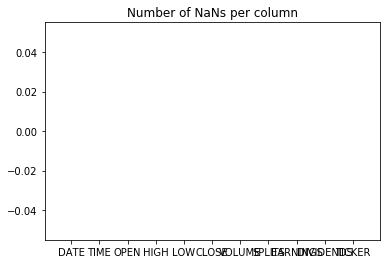

In [4]:
plt.figure()

cols = df_ticker.columns
counts = [df_ticker[x].isna().sum() for x in cols]

plt.bar(cols, counts)
plt.title("Number of NaNs per column")

In [5]:
def convert_datetime(date, time):
    ymd = date.astype("str")
    hm = time.astype("str")
    year = ymd.apply(lambda x: x[:4])
    month = ymd.apply(lambda x: x[4:6])
    day = ymd.apply(lambda x: x[6:])
    hour = hm.apply(lambda x: x[:-2])
    minute = hm.apply(lambda x: x[-2:])

    return pd.to_datetime(dict(year=year, month=month, day=day, hour=hour, minute=minute))

In [6]:
df_ticker["TIMESTAMP"] = convert_datetime(df_ticker['DATE'], df_ticker['TIME'])

df_ticker = df_ticker.sort_values(by='TIMESTAMP')

df_goog = df_ticker.query("TICKER =='GOOG'").reset_index()
df_googl = df_ticker.query("TICKER =='GOOGL'").reset_index()

In [7]:
print(df_goog.shape)
print(df_googl.shape)

(203591, 13)
(203636, 13)


The GOOG dataset has a different length than the GOOGL dataset, indicating that these dataframes have missing rows. 

From the QuantQuote website: 

Missing data for certain minutes generally means that no trades occurred during that minute. This can happen for less liquid equities which are not frequently traded. There are also situations where trades were cancelled by the exchange after being flagged by regulators or trading is halted in advance of major announcements.

Therefore, we should attempt to fill in these columns with duplicate values for the price and 0 volume for the sake of our time series analysis. 

In [8]:
goog_missing_times = set(df_goog.TIMESTAMP).difference(set(df_googl.TIMESTAMP))

googl_missing_times = set(df_googl.TIMESTAMP).difference(set(df_goog.TIMESTAMP))

total_missing_times = goog_missing_times.union(googl_missing_times)

In [9]:
df_ticker = df_ticker[~df_ticker.TIMESTAMP.isin(total_missing_times)]

In [10]:
df_goog = df_ticker.query("TICKER =='GOOG'").reset_index()
df_googl = df_ticker.query("TICKER =='GOOGL'").reset_index()

print(df_goog.shape)
print(df_googl.shape)

(203453, 13)
(203453, 13)


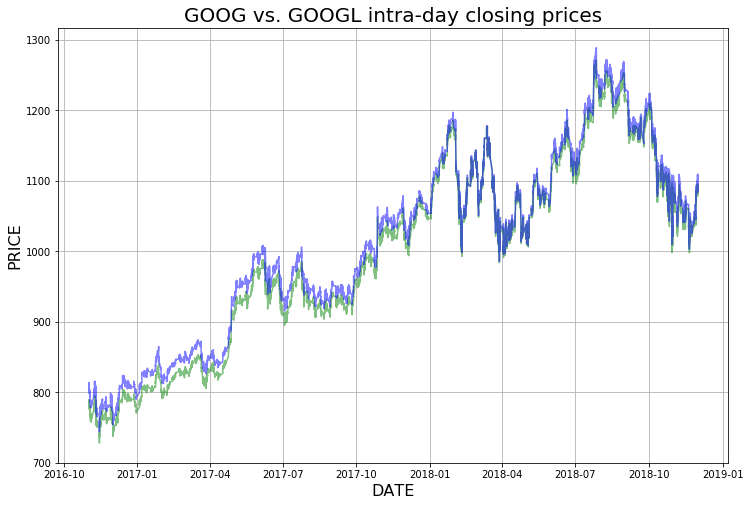

In [11]:
plt.figure(figsize=(12, 8))

plt.plot(df_goog["TIMESTAMP"], df_goog["CLOSE"], color='green', alpha=0.5, label='GOOG')
plt.plot(df_googl["TIMESTAMP"], df_googl["CLOSE"], color='blue', alpha=0.5, label='GOOGL')

plt.title('GOOG vs. GOOGL intra-day closing prices', fontsize=20)
plt.xlabel('DATE', fontsize=16)
plt.ylabel('PRICE', fontsize=16)

plt.grid()

It can be seen here that the relationship between GOOGL and GOOG shifts through our timeframe. The spread of the pricing of the stock has become narrower as time has progressed. 

This means that any potential means of capturing statistical arbitrage should factor this shift throughout time and adjust accordingly. 

In [13]:
df_goog.to_csv('./df_goog.csv')
df_googl.to_csv('./df_googl.csv')